In [1]:
import json, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors

from scipy import stats

import pytz 

from datetime import timedelta, datetime

from research.utils.data_access_utils import RDSAccessUtils

In [7]:
rds_access_utils = RDSAccessUtils(json.load(open(os.environ['DATA_WAREHOUSE_SQL_CREDENTIALS'])))

In [114]:
queryCache = {}

In [ ]:
sections = [
    'HEAD',
    'DORSAL_POSTERIOR',
    'DORSAL_ANTERIOR',
    'VENTRAL_POSTERIOR',
    'VENTRAL_ANTERIOR'
]

categories = [
    'ADULT_FEMALE',
    'MOVING'
]

In [170]:
# dfs = []

dfs.append(df)

In [173]:
df = pd.concat(dfs)

In [169]:
# '2020-06-18'

query = '''
    SELECT pen_id, captured_at::date as date, annotation FROM prod.crop_annotation
    WHERE captured_at >= '2021-03-01' 
    AND captured_at < '2021-04-01'
    AND service_id = 1
    AND annotation_state_id = 7
'''

if query in queryCache:
    df = queryCache[query].copy()
else:
    df = rds_access_utils.extract_from_database(query)

    queryCache[query] = df
    
# df.index = df['captured_at']
# df['date'] = df.captured_at.dt.date
df = df.sort_index()

# df.iloc[0]['annotation']

In [177]:
len(pen_ids)

74

In [176]:
dates = sorted(list(set(df.date)))
pen_ids = sorted(list(set(df.pen_id)))

In [178]:
all_counts = np.zeros((len(pen_ids), len(dates), len(sections), 3))

for pen_index, pen_id in enumerate(pen_ids):
    for index, date in enumerate(dates):
        df1 = df[(df.pen_id == pen_id) & (df.date == date)]

        counts = np.zeros((len(df1), len(sections), 3))

        count = 0

        for _, row in df1.iterrows():
            if 'lice' in row['annotation']:
                for lice in row['annotation']['lice']:
                    if 'bodySection' not in lice:
                        print(lice)
                    section_id = sections.index(lice['bodySection'])

                    if lice['liceLocation'] == 'MIDDLE':
                        contribution = 1
                    else:
                        contribution = 0.5

                    if lice['category'] == 'ADULT_FEMALE':
                        counts[count, section_id, 1] = counts[count, section_id, 1] + contribution
                    elif lice['category'] == 'MOVING':
                        counts[count, section_id, 2] = counts[count, section_id, 2] + contribution

            if 'visibleBodySections' not in row['annotation']:
                row['annotation']['visibleBodySections'] = []
                        
            for section in row['annotation']['visibleBodySections']:
                section_id = sections.index(section)

                counts[count, section_id, 0] = counts[count, section_id, 0] + 1

            count = count + 1

            all_counts[pen_index, index, :, 0] = np.sum(counts[:,:,0], 0)
            all_counts[pen_index, index, :, 1] = np.sum(counts[:,:,1], 0)
            all_counts[pen_index, index, :, 2] = np.sum(counts[:,:,2], 0)

In [179]:
centered_counts = np.zeros((len(pen_ids), len(dates), len(sections), 3))

for pen_index, pen_id in enumerate(pen_ids):
    for i in np.arange(1, len(dates) - 2):
        centered_counts[pen_index, i, :, 0] = np.sum(all_counts[pen_index, (i-1):(i+1),:,0], 0)
        centered_counts[pen_index, i, :, 1] = np.sum(all_counts[pen_index, (i-1):(i+1),:,1], 0) / np.sum(all_counts[pen_index, (i-1):(i+1),:,0], 0)
        centered_counts[pen_index, i, :, 2] = np.sum(all_counts[pen_index, (i-1):(i+1),:,2], 0) / np.sum(all_counts[pen_index, (i-1):(i+1),:,0], 0)

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


In [180]:
final_counts = np.zeros((len(pen_ids), len(dates), 3))

for pen_index, pen_id in enumerate(pen_ids):
    for i in np.arange(2, len(dates) - 3):
        final_counts[pen_index, i, 0] = np.min(np.sum(centered_counts[pen_index, (i-1):(i+1),:,0], 0))
        final_counts[pen_index, i, 1] = np.sum(np.mean(centered_counts[pen_index, (i-1):(i+1),:,1], 0))
        final_counts[pen_index, i, 2] = np.sum(np.mean(centered_counts[pen_index, (i-1):(i+1),:,2], 0))

In [183]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [240]:
datetime.strptime('2020-07-01', '%Y-%m-%d')

datetime.datetime(2020, 7, 1, 0, 0)

In [ ]:
np.sum(final_counts[:,:,0] > 0)

In [286]:
np.sum(final_counts[:,:,0] > 40) / np.sum(final_counts[:,:,0] > 0)

0.8525402726146221

In [285]:
dates = np.array(dates)

d1 = '2020-07-01'
d2 = '2020-08-01'

mask = (dates >= datetime.strptime(d1, '%Y-%m-%d').date()) & (dates < datetime.strptime(d2, '%Y-%m-%d').date())

for kpi in [25, 40, 50, 75, 100]:
    print(kpi, np.sum(final_counts[:,mask,0] > kpi) / np.sum(final_counts[:,mask,0] > 0))

25 0.7490974729241877
40 0.6570397111913358
50 0.6010830324909747
75 0.44945848375451264
100 0.34115523465703973


In [292]:
af_counts = []

for pen_index, pen_id in enumerate(pen_ids):
    mask = final_counts[pen_index,:,0] > 40
    af_counts.append(final_counts[pen_index,mask,1])
    
a = np.concatenate(af_counts)

1.0 / 40 / np.mean(a[~(np.isnan(a) | ~np.isfinite(a))])
# np.std(a[~(np.isnan(a) | ~np.isfinite(a))]) / np.sqrt(40)



0.06674614237501296

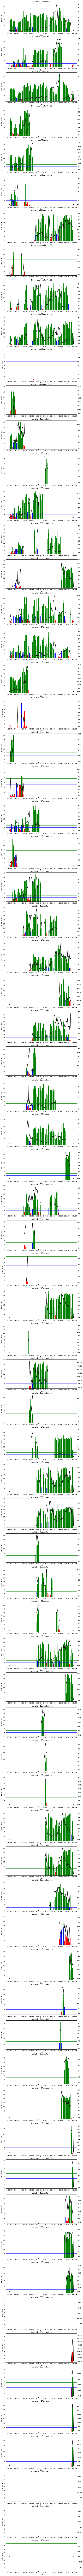

In [260]:
fig, axes = plt.subplots(len(pen_ids), 1, figsize=(10, 5 * len(pen_ids)))

for pen_index, pen_id in enumerate(pen_ids):
    ax = axes[pen_index]
    
    ax1 = ax.twinx()

    mask = final_counts[pen_index,:,0] > 75
    mask2 = final_counts[pen_index,:,0] > 50

    date_plot = np.array(dates)
    date_plot1 = np.array(dates)[mask]
    date_plot2 = np.array(dates)[mask2 & ~mask]
    date_plot3 = np.array(dates)[~mask2]
    
    ax.bar(date_plot1, final_counts[pen_index,mask,0], color = 'green')
    ax.bar(date_plot2, final_counts[pen_index,mask2 & ~mask,0], color = 'blue')
    ax.bar(date_plot3, final_counts[pen_index,~mask2,0], color = 'red')
    ax.axhline(y = 75, color = 'green')
    ax.axhline(y = 50, color = 'blue')
    ax1.plot(date_plot, final_counts[pen_index,:,2], color = 'black')
    
    ax.set_title('Mobile Lice Counts: Pen %i' % (pen_id, ))
    ax.set_xlabel('Date')
    ax.set_ylabel('Mobile count')

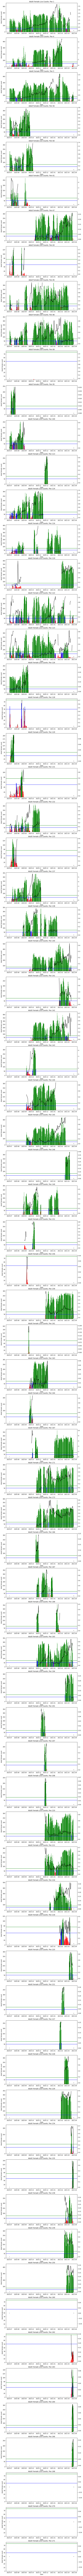

In [261]:
fig, axes = plt.subplots(len(pen_ids), 1, figsize=(10, 5 * len(pen_ids)))

for pen_index, pen_id in enumerate(pen_ids):
    ax = axes[pen_index]
    
    ax1 = ax.twinx()

    mask = final_counts[pen_index,:,0] > 75
    mask2 = final_counts[pen_index,:,0] > 50

    date_plot = np.array(dates)
    date_plot1 = np.array(dates)[mask]
    date_plot2 = np.array(dates)[mask2 & ~mask]
    date_plot3 = np.array(dates)[~mask2]
    
    ax.bar(date_plot1, final_counts[pen_index,mask,0], color = 'green')
    ax.bar(date_plot2, final_counts[pen_index,mask2 & ~mask,0], color = 'blue')
    ax.bar(date_plot3, final_counts[pen_index,~mask2,0], color = 'red')
    ax.axhline(y = 75, color = 'green')
    ax.axhline(y = 50, color = 'blue')
    ax1.plot(date_plot, final_counts[pen_index,:,1], color = 'black')
    
    ax.set_title('Adult Female Lice Counts: Pen %i' % (pen_id, ))
    ax.set_xlabel('Date')
    ax.set_ylabel('Adult female count')

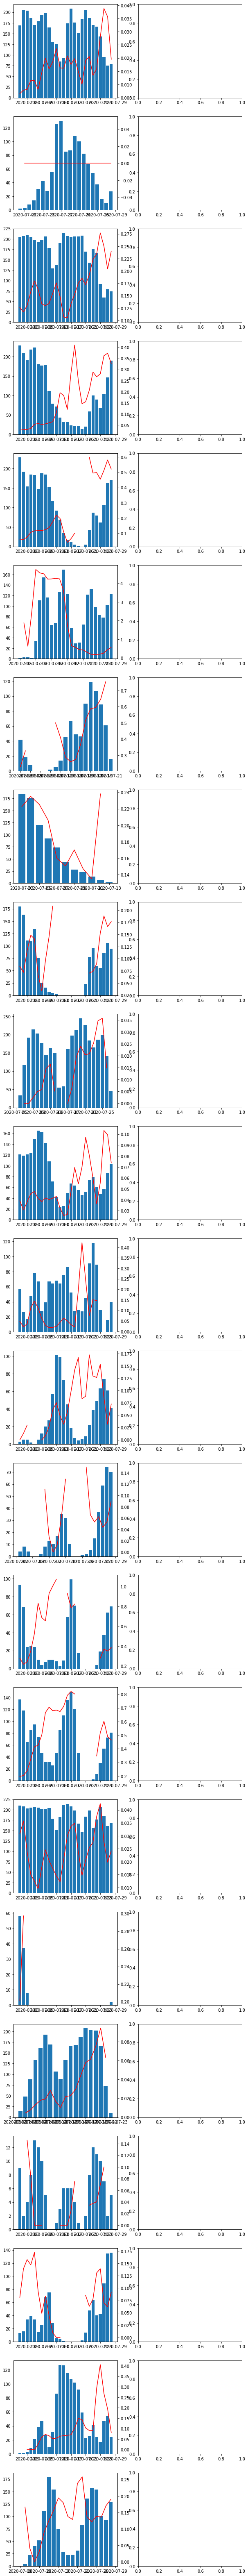

In [150]:
fig, axes = plt.subplots(len(pen_ids), 2, figsize=(10, 5 * len(pen_ids)))

for pen_index, pen_id in enumerate(pen_ids):
    ax = axes[pen_index, 0]
    
    ax1 = ax.twinx()

    mask = final_counts[pen_index,:,0] > 0

    date_plot = np.array(dates)[mask]
    
    ax.bar(date_plot, final_counts[pen_index,mask,0])
    ax1.plot(date_plot, final_counts[pen_index,mask,1], color = 'red')

In [48]:
np.sum(counts[:,:,1], 0) / np.sum(counts[:,:,0], 0)

array([0.        , 0.05555556, 0.        , 0.01515152, 0.        ])

In [29]:
df.iloc[4]['annotation']

{'lice': [{'width': 72,
   'xCrop': 653,
   'yCrop': 686,
   'height': 39,
   'category': 'ADULT_FEMALE',
   'bodySection': 'DORSAL_POSTERIOR',
   'liceLocation': 'TOP'}],
 'isPartial': True,
 'visibleBodySections': ['DORSAL_POSTERIOR',
  'VENTRAL_POSTERIOR',
  'VENTRAL_ANTERIOR']}

In [42]:
for index, row in df.iterrows():
    if 'lice' in row['annotation']:
        for lice in row['annotation']['lice']:
            print(lice['liceLocation'])

TOP
TOP
TOP
TOP
BOTTOM
MIDDLE
TOP
MIDDLE
TOP
TOP
TOP
TOP
TOP
MIDDLE
BOTTOM
TOP
TOP
TOP
BOTTOM
TOP
BOTTOM
TOP
TOP
TOP
BOTTOM
BOTTOM
TOP
TOP
TOP
BOTTOM
BOTTOM
BOTTOM
BOTTOM
TOP
TOP
MIDDLE
TOP
TOP
MIDDLE
MIDDLE
TOP
MIDDLE
TOP
BOTTOM
BOTTOM
MIDDLE
MIDDLE
TOP
TOP
TOP
BOTTOM
TOP
TOP
BOTTOM
TOP
MIDDLE
MIDDLE
BOTTOM
MIDDLE
TOP
BOTTOM
BOTTOM
BOTTOM
MIDDLE
MIDDLE
MIDDLE
TOP
MIDDLE
TOP
TOP
TOP
TOP
BOTTOM
TOP
TOP
TOP
TOP
TOP
BOTTOM
BOTTOM
TOP
TOP
TOP
TOP
TOP
TOP
TOP
BOTTOM
TOP
TOP
TOP
TOP
MIDDLE
TOP
TOP
TOP
MIDDLE
TOP
TOP
TOP
TOP
TOP
TOP
MIDDLE
MIDDLE
TOP
MIDDLE
TOP
TOP
BOTTOM
TOP
TOP
TOP
TOP
TOP
MIDDLE
TOP
TOP
MIDDLE
TOP
MIDDLE
TOP
MIDDLE
TOP
TOP
TOP
TOP
TOP
TOP
BOTTOM
BOTTOM
TOP
BOTTOM
TOP
TOP
BOTTOM
BOTTOM
TOP
TOP
TOP
BOTTOM
BOTTOM
BOTTOM
TOP
MIDDLE
MIDDLE
TOP
BOTTOM
MIDDLE
TOP
TOP
TOP
MIDDLE
TOP
BOTTOM
MIDDLE
TOP
TOP
TOP
TOP
BOTTOM
TOP
TOP
MIDDLE
BOTTOM
TOP
MIDDLE
TOP
BOTTOM
MIDDLE
TOP
MIDDLE
TOP
MIDDLE
TOP
TOP
TOP
TOP
TOP
MIDDLE
MIDDLE
MIDDLE
MIDDLE
TOP
TOP
TOP
TOP
TOP
TOP
MIDDLE
TOP
TOP
BOTT

In [16]:
df.iloc[4]

service_id                                                             1
pen_id                                                               114
annotation_state_id                                                    7
base_key               environment=production/site-id=60/pen-id=114/d...
url_key                https://aquabyte-crops.s3.eu-west-1.amazonaws....
right_crop_url         https://aquabyte-crops.s3.eu-west-1.amazonaws....
left_crop_metadata     {'width': 2419, 'height': 1505, 'x_coord': 0, ...
right_crop_metadata    {'width': 2251, 'height': 1466, 'x_coord': 0, ...
camera_metadata        {'baseline': 0.10496815505108442, 'focalLength...
annotation             {'lice': [{'width': 72, 'xCrop': 653, 'yCrop':...
captured_at                             2020-11-02 08:32:44.205177+00:00
ts_source_start                                2020-11-02 13:27:51+00:00
ts_source_end                                                        NaT
ts                                      2020-11-02 

In [4]:
# pen_id = 201
# df_start_date = '2020-11-01'
# df_end_date = '2020-11-25'

# query = """
#     select captured_at, annotation_metadata, annotated_by_email
#     from annotations a
#     where a.pen_id = %i
#     and a.is_qa = true
#     and a.is_skipped = false
#     and a.captured_at > '%s'
#     and a.captured_at < '%s';
# """ % (pen_id, df_start_date, df_end_date)

# if query in queryCache:
#     df = queryCache[query]
# else:
#     df = rds_access_utils.extract_from_database(query)

#     queryCache[query] = df
    
# df.index = df['captured_at']

# df['date'] = df.captured_at.dt.date

# df = df.sort_index()

# for index, lice_count in df.iterrows():
#     liceCounts = lice_count['annotation_metadata']['liceCounts']

#     df.loc[index, 'movingCountAdjusted'] = liceCounts['movingCountAdjusted']
#     df.loc[index, 'adultFemaleCountAdjusted'] = liceCounts['adultFemaleCountAdjusted']
#     df.loc[index, 'count'] = 1


In [6]:
df.iloc[0]['annotation_metadata']['liceCounts']

{'fixedCount': 0,
 'movingCount': 0,
 'unsureCount': 0,
 'adultFemaleCount': 0,
 'fixedCountAdjusted': 0,
 'movingCountAdjusted': 0,
 'unsureCountAdjusted': 0,
 'adultFemaleCountAdjusted': 0,
 'scottishAdultFemaleCount': 0,
 'scottishAdultFemaleCountAdjusted': 0}